In [1]:
# Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Adjust PATHs

## Location in directory
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
cat('Directory: ', getwd())

## Conda environment
conda_env <- paste0('/home/',Sys.getenv('USER'),'/miniconda3/envs/arabinosylation-anti-crispr/bin')
PATH <- Sys.getenv('PATH')
if (!str_detect(PATH, conda_env)) {
    Sys.setenv('PATH' = paste(conda_env, PATH, sep = ':'))
}
Sys.getenv('PATH')

Directory:  /projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR

[1] "/home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin:/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin"

In [3]:
# Load internal functions
source('bin/utils.R')

In [4]:
# Define variables

in_tables <- 'docs/supplementary-tables.xlsx'
overview <- 'data/overview.csv'

fn <- list(
    'overview' = 'data/overview.csv',
    'training' = 'data/training/accession.txt',
    'validation' = 'data/validation/accession.txt',
    'test' = 'data/test/accession.txt'
)
for (i in names(fn)) {
    dir.create(dirname(fn[[i]]))
}

Warning message in dir.create(dirname(fn[[i]])):
“'data' already exists”
Warning message in dir.create(dirname(fn[[i]])):
“'data/training' already exists”
Warning message in dir.create(dirname(fn[[i]])):
“'data/validation' already exists”
Warning message in dir.create(dirname(fn[[i]])):
“'data/test' already exists”


In [5]:
# Read supplementary tables
tables <- list()
for (i in excel_sheets(in_tables)) {
    print(paste('Reading table', i))
    tables[[i]] <- read_excel(in_tables, sheet = i)
    }

[1] "Reading table phages"
[1] "Reading table predicted_arabinosylating_phage"
[1] "Reading table S7_phage-genomes"
[1] "Reading table proteins"
[1] "Reading table S4_phages"
[1] "Reading table S1_bacteria"
[1] "Reading table S6_ara-hC-transferases"
[1] "Reading table S8_glucosylation-enzymes"
[1] "Reading table S9_DNA-modification-enzymes"


In [6]:
# NCBI Query
queries <- list(
    c('nuccore',"Phage sequences","phage[TITL] OR bacteriophage[TITL]"),
    c('nuccore',"Phage genomes","(phage[TITL] OR bacteriophage[TITL]) AND (genome[TITL] OR complete sequence[TITL])"),
    c('nuccore','INPHARED','"gbdiv_PHG"[prop]')
)
queries <- as.data.frame(t(as.data.frame(queries)))
colnames(queries) <- c('db','name','term')
rownames(queries) <- 1:nrow(queries)

# Entrez call
queries$count <- NA
for (i in 1:nrow(queries)) {
    queries$count[[i]] <- entrez_search(db = queries$db[[i]], term = queries$term[[i]], retmax=0)$count
}

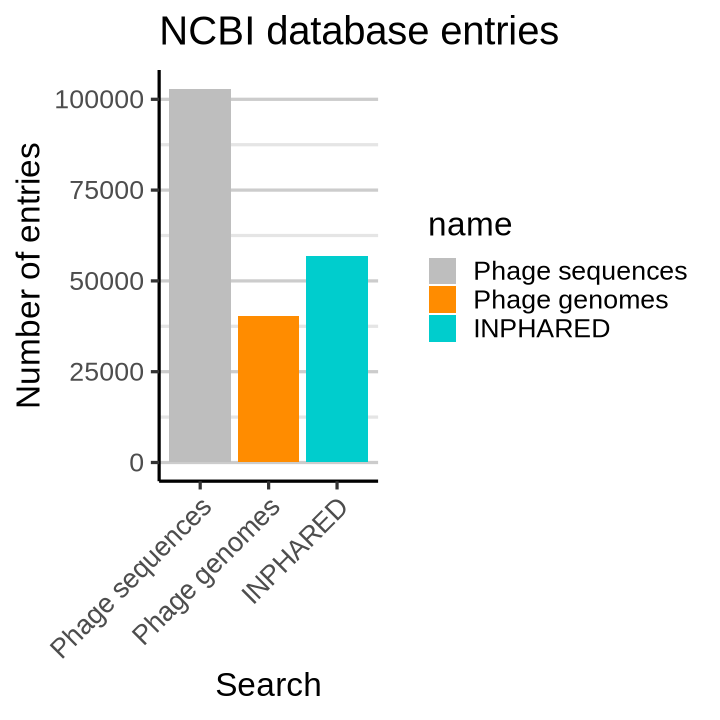

In [8]:
# Visualize
options(repr.plot.width=6, repr.plot.height=6)

## Order
queries$name <- factor(queries$name, unique(queries$name))

## Plot
ggplot(queries, aes(name, count, fill=name)) +
  geom_col() +
  scale_fill_manual(values = c('grey','darkorange','cyan3')) +
  theme_classic(20) +
  theme(
      panel.grid.major.y = element_line(color = 'grey80'),
      panel.grid.minor.y = element_line(color = 'grey90'),
      axis.text.x = element_text(angle=45,hjust=1,vjust=1)
  ) +
  labs(title='NCBI database entries', x = 'Search', y = 'Number of entries')

In [21]:
# NCBI query to obtain entrez IDs
result <- list()
for (i in c('Phage genomes','INPHARED')) {
    query <- queries$term[queries$name == i]
    result[[i]] <- entrez_search(db='nuccore', term=query, retmax=90000)
}

## Intersect
ids_intersect <- intersect(result$`Phage genomes`$ids, result$INPHARED$ids)
length(ids_intersect)

## Union
ids_union <- union(result$`Phage genomes`$ids, result$INPHARED$ids)
length(ids_union)

[1] 27454

[1] 69721

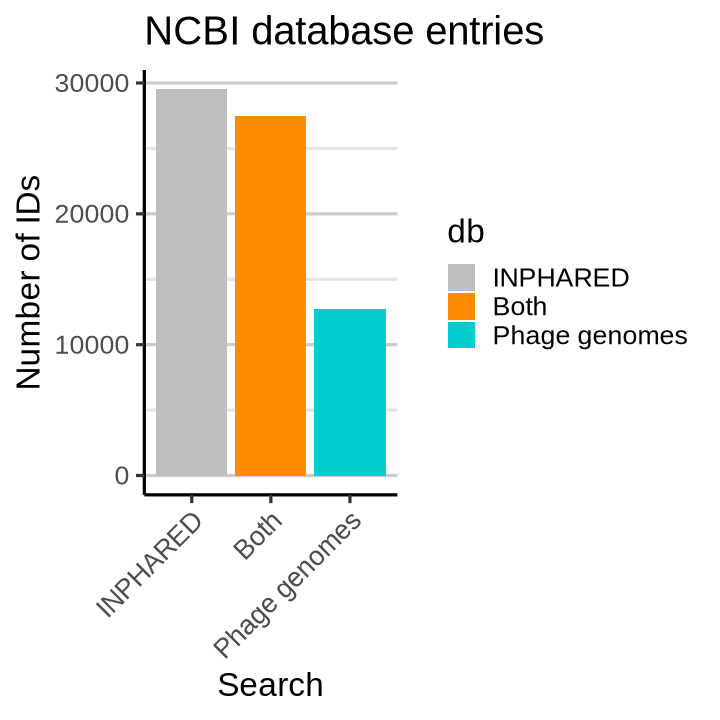

In [32]:
# Visualize ID overlap (would be better as sankey)
options(repr.plot.width=6, repr.plot.height=6)

## Wrangle
df <- data.frame(
    ids = ids_union
)
df$db <- NA
df$db[df$ids %in% result$`Phage genomes`$ids] <- 'Phage genomes'
df$db[df$ids %in% result$INPHARED$ids & is.na(df$db)] <- 'INPHARED'
df$db[df$ids %in% result$INPHARED$ids & df$db == 'Phage genomes'] <- 'Both'
df$N <- 1

## Summarize
df <- df %>% group_by(db) %>% summarize(entries = sum(N, na.rm = TRUE))
df$db <- factor(df$db, c('INPHARED','Both','Phage genomes'))

## Plot
ggplot(df, aes(db, entries, fill=db)) +
  geom_col() +
  scale_fill_manual(values = c('grey','darkorange','cyan3')) +
  theme_classic(20) +
  theme(
      panel.grid.major.y = element_line(color = 'grey80'),
      panel.grid.minor.y = element_line(color = 'grey90'),
      axis.text.x = element_text(angle=45,hjust=1,vjust=1)
  ) +
  labs(title='NCBI database entries', x = 'Search', y = 'Number of IDs')

In [23]:
# Convert entrez ID to nucleotide accession

query <- data.frame(
    entrez = ids_union
)

## Create groups of IDs
n_groups <- ceiling(nrow(query) / 100)
query$group <- factor(sample(1:n_groups, nrow(query), replace=TRUE))

## Convert entrez to accession
query$accession <- NA
for (i in levels(query$group)) {
    ind <- which(query$group==i)
    # Accession
    x <- entrez_fetch(db='nuccore', id=query$entrez[ind], rettype='acc')
    query$accession[ind] <- head(str_split(x, "\\n")[[1]], -1)
}

## View
rbind(head(query,3), tail(query,3))

,entrez,group,accession
,<chr>,<fct>,<chr>
1,2890096451,655,PL089164.1
2,2890096449,333,PL089163.1
3,2743645791,353,PP777464.1
69719,166167,502,J02446.1
69720,166152,539,J02445.1
69721,166109,595,M13491.1


In [33]:
# Check IDs

## Unique
length(unique(query$entrez))
length(unique(query$accession))

## Overlap of query and selection
table(tables$phages$accession %in% query$accession)

## Data split
table(query$type)

[1] 69721

[1] 69721


TRUE 
  35 

< table of extent 0 >

In [34]:
# Check phages with annotated proteins
sel <- tables$proteins
sel$genome_accession <- NA
for (n in 1:nrow(sel)) {
    # Select ID
    i <- sel$protein_accession[[n]]

    # Error handling
    if (is.na(i)) {next}

    # Run ENTREZ query
    report <- try(entrez_fetch(db="protein", id=i, rettype = 'jsonl'))

    # Skip unknown sequences
    if (class(report) == 'try-error') {next}
    
    # Get NCBI protein report
    report <- str_split(report, '\n')[[1]] # Split into lines
    index <- which(str_detect(report, 'DBSOURCE')) # Detect which line (usually 5)
    db_source <- report[[index]]
    db_source <- str_split(db_source, '\\ ')[[1]]
    db_source <- db_source[[length(db_source)]] # Select last element
    sel$genome_accession[[n]] <- db_source
}

Error : HTTP failure: 400
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eEfetchResult PUBLIC "-//NLM//DTD efetch 20131226//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20131226/efetch.dtd">
<eFetchResult>
	<ERROR> Error: CEFetchPApplication::proxy_stream(): Error: F a i l e d  t o  u n d e r s t a n d  i d :  C W C 4 6 _ 0 9 1 0 5 &#xa;&#xa;</ERROR>
</eFetchResult>

Error : HTTP failure: 400
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eEfetchResult PUBLIC "-//NLM//DTD efetch 20131226//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20131226/efetch.dtd">
<eFetchResult>
	<ERROR> Error: CEFetchPApplication::proxy_stream(): Error: F a i l e d  t o  u n d e r s t a n d  i d :  C W C 4 6 _ 0 9 1 0 5 &#xa;&#xa;</ERROR>
</eFetchResult>



In [35]:
# Comparing accession numbers

## Check overlap
index <- sel$genome_accession %in% query$accession
table(index)

## Detect missing genomes
unique(sel$genome_accession[which(!index)])

## Manually add entries to query
entries <- list(
    data.frame(entrez='',group='manual',accession='OP946501.1'),
    data.frame(entrez='',group='manual',accession='OP946502.1'),
    data.frame(entrez='',group='manual',accession='OZ038340.1')
)
entries <- bind_rows(entries)
query <- rbind(query, entries)

## Select unique accession numbers
query <- query[!duplicated(query$accession), ]

index
FALSE  TRUE 
   11   212 

[1] NA           "CP056784.2" "J01710.1"   "CP053607.1"

In [36]:
# Split data into types

## Test/Training data
query$type <- 'test'
query$type[query$accession %in% tables$phages$accession] <- 'training'

## Validation
index <- which(query$type == 'test' & query$accession %in% sel$genome_accession)
query$type[index] <- 'validation'

index <- which(query$group == 'manual')
query$type[index] <- 'validation'

## View
rbind(head(query,3), tail(query,3))

## Check data split
table(query$type)

,entrez,group,accession,type
,<chr>,<fct>,<chr>,<chr>
1,2890096451,655,PL089164.1,test
2,2890096449,333,PL089163.1,test
3,2743645791,353,PP777464.1,test
69719,166167,502,J02446.1,test
69720,166152,539,J02445.1,test
69721,166109,595,M13491.1,test



      test   training validation 
     69593         35         93 

In [37]:
# Export accession numbers
write.table(query, fn$overview, sep = ',', quote = FALSE, row.names = FALSE)

## Training data
index <- which(query$type == 'training')
writeLines(query$accession[index], fn$training)

## Validation data
index <- which(query$type == 'validation')
writeLines(query$accession[index], fn$validation)

## Test data
index <- which(query$type == 'test')
writeLines(query$accession[index], fn$test)

In [38]:
# Download training data
download_ncbi_genomes(inputfile = fn$training, overwrite = TRUE)

Warning message in download_ncbi_genomes(inputfile = fn$training, overwrite = TRUE):
“Overwrite flag set. Removing output.”
Warning message in file.remove(zipfile):
“cannot remove file 'data/training/ncbi_dataset.zip', reason 'No such file or directory'”


datasets download virus genome accession --inputfile data/training/accession.txt --filename data/training/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/training/download.log 2>&1 

Unzip



Checksums identical. Files were downloaded without problems.



dataformat tsv virus-annotation --inputfile data/training/ncbi_dataset/data/annotation_report.jsonl > data/training/ncbi_dataset/data/features.gtf 

dataformat tsv virus-genome --inputfile data/training/ncbi_dataset/data/data_report.jsonl > data/training/ncbi_dataset/data/metadata.tsv 



All accession IDs retrieved successfully



Done.

In [39]:
# Download validation data
download_ncbi_genomes(inputfile = fn$validation, overwrite = TRUE)

Warning message in download_ncbi_genomes(inputfile = fn$validation, overwrite = TRUE):
“Overwrite flag set. Removing output.”
Warning message in file.remove(zipfile):
“cannot remove file 'data/validation/ncbi_dataset.zip', reason 'No such file or directory'”


datasets download virus genome accession --inputfile data/validation/accession.txt --filename data/validation/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/validation/download.log 2>&1 

Unzip



Checksums identical. Files were downloaded without problems.



dataformat tsv virus-annotation --inputfile data/validation/ncbi_dataset/data/annotation_report.jsonl > data/validation/ncbi_dataset/data/features.gtf 

dataformat tsv virus-genome --inputfile data/validation/ncbi_dataset/data/data_report.jsonl > data/validation/ncbi_dataset/data/metadata.tsv 



All accession IDs retrieved successfully



Done.

In [40]:
# Download test data
download_ncbi_genomes(inputfile = fn$test, overwrite = TRUE)

Warning message in download_ncbi_genomes(inputfile = fn$test, overwrite = TRUE):
“Overwrite flag set. Removing output.”
Warning message in file.remove(zipfile):
“cannot remove file 'data/test/ncbi_dataset.zip', reason 'No such file or directory'”


datasets download virus genome accession --inputfile data/test/accession.txt --filename data/test/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/test/download.log 2>&1 

Unzip



Checksums identical. Files were downloaded without problems.



dataformat tsv virus-annotation --inputfile data/test/ncbi_dataset/data/annotation_report.jsonl > data/test/ncbi_dataset/data/features.gtf 

dataformat tsv virus-genome --inputfile data/test/ncbi_dataset/data/data_report.jsonl > data/test/ncbi_dataset/data/metadata.tsv 



Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in download_ncbi_genomes(inputfile = fn$test, overwrite = TRUE):
“Not all accession IDs retrieved. Exporting missing IDs...”


Entries retrieved: 22467 of 69593 

Done.

In [47]:
# Find missing entries
acc <- readLines('data/test/missing_accessions.txt')
length(acc)

[1] 47126

In [49]:
dir.create('data/test2/', recursive = TRUE)
file.copy('data/test/missing_accessions.txt','data/test2/accession.txt')

[1] TRUE

In [50]:
## Download missing genomes (into different archive, iterate)
download_ncbi_genomes('data/test2/accession.txt', overwrite = TRUE)

datasets download virus genome accession --inputfile data/test2/accession.txt --filename data/test2/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/test2/download.log 2>&1 

Unzip



Checksums identical. Files were downloaded without problems.



dataformat tsv virus-annotation --inputfile data/test2/ncbi_dataset/data/annotation_report.jsonl > data/test2/ncbi_dataset/data/features.gtf 

dataformat tsv virus-genome --inputfile data/test2/ncbi_dataset/data/data_report.jsonl > data/test2/ncbi_dataset/data/metadata.tsv 



Warning message in download_ncbi_genomes("data/test2/accession.txt", overwrite = TRUE):
“Not all accession IDs retrieved. Exporting missing IDs...”


Entries retrieved: 44226 of 47126 

Done.

In [61]:
# Find missing entries
acc <- readLines('data/test2/missing_accessions.txt')
length(acc)

[1] 2900

In [53]:
dir.create('data/test3/', recursive = TRUE)
file.copy('data/test2/missing_accessions.txt','data/test3/accession.txt')

Warning message in dir.create("data/test3/", recursive = TRUE):
“'data/test3' already exists”


[1] TRUE

In [54]:
## Download missing genomes (into different archive, iterate)
download_ncbi_genomes('data/test3/accession.txt')

datasets download virus genome accession --inputfile data/test3/accession.txt --filename data/test3/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/test3/download.log 2>&1 



Warning message in system(call_datasets, intern = TRUE):
“running command 'datasets download virus genome accession --inputfile data/test3/accession.txt --filename data/test3/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/test3/download.log 2>&1' had status 1”


Unzip



Warning message in unzip(zipfile, exdir = PATH):
“error 1 in extracting from zip file”
Warning message in file(file, "rt"):
“cannot open file 'data/test3/md5sum.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [55]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.5.1 tidyr_1.3.1   dplyr_1.1.4   rentrez_1.2.3 stringr_1.5.1
[6] readxl_1.4.3 

loaded via a namespace (and not attached):
 [1] gtable_0.3.6      jsonlite_1.8.9    compiler_4.4.2    crayon_1.5.3     
 [5] tidyselect_1.2.1  IRdisplay_1.1     scales_1.3.0      uu